Dejo un requirements.txt para que corra este pipeline en: <code>/entorno_conda/tfm-ml/requirements.txt</code>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, explained_variance_score

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor, HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import FunctionTransformer
from skops.io import dump, load, get_untrusted_types
from zipfile import ZIP_DEFLATED

In [2]:

# 1. Carga de datos
# completo = pd.read_csv('transform_listings.csv')
completo = pd.read_csv('transform_listings_con_distancias_red_transporte.csv')
df = completo[['neighbourhood_group_cleansed','bedrooms', 'bathrooms', 'price','latitude','longitude','DISTANCE_TO_METRO','DISTANCE_TO_CERCANIAS','DISTANCE_TO_EMT','DISTANCE_TO_INTERURBANOS','DISTANCE_TO_MLO']]
df


,neighbourhood_group_cleansed,bedrooms,bathrooms,price,latitude,longitude,DISTANCE_TO_METRO,DISTANCE_TO_CERCANIAS,DISTANCE_TO_EMT,DISTANCE_TO_INTERURBANOS,DISTANCE_TO_MLO
0,Centro,1,1,66.0,40.423810,-3.710380,65.550156,891.965871,12.560164,900.746796,7264.107058
1,Centro,1,1,89.0,40.422520,-3.702500,284.978036,631.600135,57.027035,1512.088715,7077.364017
2,Centro,3,1,173.0,40.411500,-3.704490,95.482753,605.845021,116.820438,1024.485790,8264.204209
3,Centro,1,1,72.0,40.408660,-3.703740,241.641665,403.344436,112.846345,902.627954,6146.067885
4,Centro,3,1,189.0,40.409390,-3.698120,255.405162,608.010047,229.327136,436.363883,6629.512164
...,...,...,...,...,...,...,...,...,...,...,...
13866,Tetuán,1,1,67.0,40.464951,-3.704578,725.855648,2284.942162,37.612176,1187.201671,3617.510431
13867,Tetuán,1,1,63.0,40.468355,-3.706939,860.673941,2438.746328,90.105679,1381.077584,5457.868016
13868,Hortaleza,1,1,103.0,40.464110,-3.647130,451.273298,2650.144067,94.570576,1761.401610,2441.782425
13869,Carabanchel,2,1,100.0,40.395983,-3.730953,689.318940,1180.965436,259.122214,769.248479,3699.565428


In [3]:
# 2.1 No hago preprocesado porque ya lo hice en el notebook de transform_listings

# más adelante filtro precios outliers para mejorar los resultados de los modelos

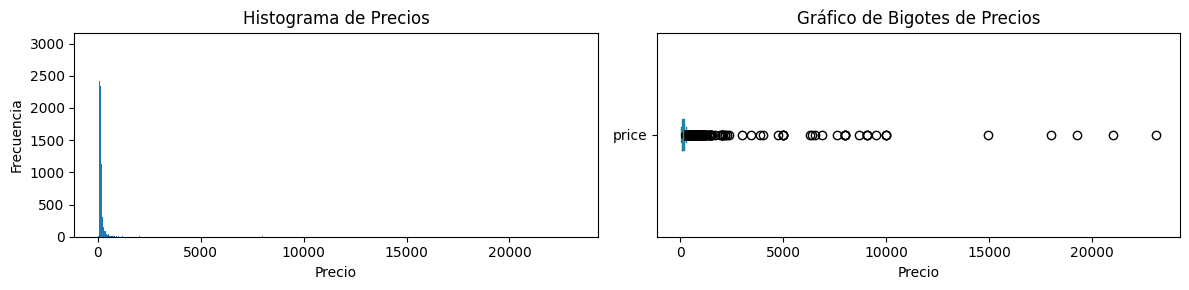

In [4]:
# Histogramay bigotes sin quitar outliers

fig, axes = plt.subplots(1, 2, figsize=(12, 3))
df['price'].plot(kind='hist', ax=axes[0], bins=1000)
# df['price'].plot(kind='hist', ax=axes[0], bins=int(np.sqrt(len(df['price']))))
axes[0].set_title('Histograma de Precios')
axes[0].set_xlabel('Precio')
axes[0].set_ylabel('Frecuencia')
df['price'].plot(kind='box', ax=axes[1], vert=False)
axes[1].set_title('Gráfico de Bigotes de Precios')
axes[1].set_xlabel('Precio')
plt.tight_layout()
plt.show()

In [5]:
# # # # Filtro los outliers utilizando el rango intercuartílico (IQR): 
# # # ¿Mejoraría algo con z-score?
Q1  = df['price'].quantile(0.25)
Q3  = df['price'].quantile(0.75)
IQR = Q3 - Q1
IQR
df = df[(df['price']>=Q1 - 1.5 * IQR) & (df['price']<=Q3 + 1.5 * IQR)]

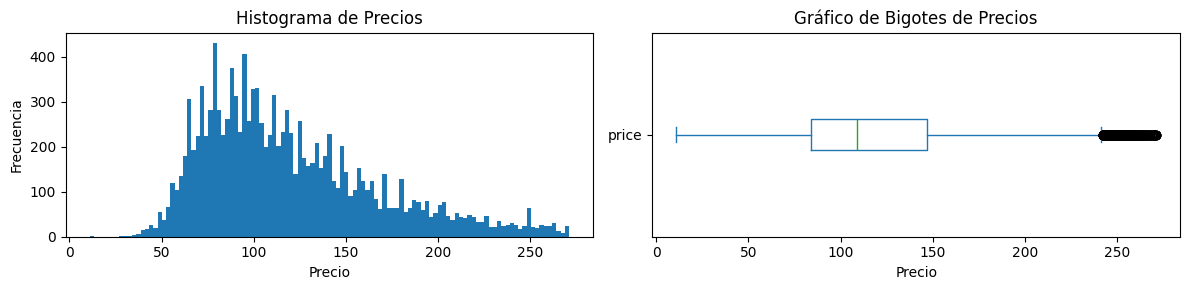

In [6]:
# Histograma y bigotes con outliers quitados (método IQR)

fig, axes = plt.subplots(1, 2, figsize=(12, 3))
df['price'].plot(kind='hist', ax=axes[0], bins=int(np.sqrt(len(df['price']))))
axes[0].set_title('Histograma de Precios')
axes[0].set_xlabel('Precio')
axes[0].set_ylabel('Frecuencia')
df['price'].plot(kind='box', ax=axes[1], vert=False)
axes[1].set_title('Gráfico de Bigotes de Precios')
axes[1].set_xlabel('Precio')
plt.tight_layout()
plt.show()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12856 entries, 0 to 13870
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   neighbourhood_group_cleansed  12856 non-null  object 
 1   bedrooms                      12856 non-null  int64  
 2   bathrooms                     12856 non-null  int64  
 3   price                         12856 non-null  float64
 4   latitude                      12856 non-null  float64
 5   longitude                     12856 non-null  float64
 6   DISTANCE_TO_METRO             12856 non-null  float64
 7   DISTANCE_TO_CERCANIAS         12856 non-null  float64
 8   DISTANCE_TO_EMT               12856 non-null  float64
 9   DISTANCE_TO_INTERURBANOS      12856 non-null  float64
 10  DISTANCE_TO_MLO               12856 non-null  float64
dtypes: float64(8), int64(2), object(1)
memory usage: 1.2+ MB


In [8]:
# densifier = FunctionTransformer(lambda X: X.toarray() if hasattr(X, "toarray") else X)

# 1. Carga y limpieza
df = df.dropna(subset=['bedrooms','bathrooms','neighbourhood_group_cleansed','price','DISTANCE_TO_METRO','DISTANCE_TO_CERCANIAS','DISTANCE_TO_EMT','DISTANCE_TO_INTERURBANOS','DISTANCE_TO_MLO'])

# 2. Separar X/y
X = df[['bedrooms','bathrooms','neighbourhood_group_cleansed','DISTANCE_TO_METRO','DISTANCE_TO_CERCANIAS','DISTANCE_TO_EMT','DISTANCE_TO_INTERURBANOS','DISTANCE_TO_MLO']]
y = df['price']

# 3. Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# 4. Preprocesador: escala numéricos + one-hot para distrito
numeric_feats = ['bedrooms','bathrooms','DISTANCE_TO_METRO','DISTANCE_TO_CERCANIAS','DISTANCE_TO_EMT','DISTANCE_TO_INTERURBANOS','DISTANCE_TO_MLO']
cat_feats     = ['neighbourhood_group_cleansed']

preprocessor = ColumnTransformer([
    ('num',   StandardScaler(),    numeric_feats),
    ('cat',   OneHotEncoder(drop='first', handle_unknown="ignore", sparse_output=False), cat_feats),
])

# 5. Definir pipelines para cada modelo
models = {
    'LinearRegression': Pipeline([('prep', preprocessor),
                                  ('reg',  LinearRegression())]),
    'Ridge':            Pipeline([('prep', preprocessor),
                                  ('reg',  Ridge(alpha=1.0, random_state=42))]),
    'Lasso':            Pipeline([('prep', preprocessor),
                                  ('reg',  Lasso(alpha=0.1, random_state=42))]),
    'ElasticNet':       Pipeline([('prep', preprocessor),
                                  ('reg',  ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42))]),
    'KNeighbors':       Pipeline([('prep', preprocessor),
                                  ('reg',  KNeighborsRegressor(n_neighbors=5))]),
    'SVR':              Pipeline([('prep', preprocessor),
                                  ('reg',  SVR(kernel='rbf', C=1.0))]),
    'RandomForest':     Pipeline([('prep', preprocessor),
                                  ('reg',  RandomForestRegressor(n_estimators=100, random_state=42))]),
    'GradientBoosting': Pipeline([('prep', preprocessor),
                                  ('reg',  GradientBoostingRegressor(
                                      n_estimators=100, learning_rate=0.1, 
                                      max_depth=3, random_state=42))]),
    'ExtraTrees': Pipeline([('prep', preprocessor),
                            ('reg', ExtraTreesRegressor(n_estimators=100, random_state=42))]),
    'AdaBoost': Pipeline([('prep', preprocessor),
                          ('reg', AdaBoostRegressor(n_estimators=100, random_state=42))]),
    'HistGradientBoosting': Pipeline([('prep', preprocessor),
                                    #   ('densify',densifier),
                                      ('reg', HistGradientBoostingRegressor(max_iter=100, random_state=42))]),
    'MLPRegressor': Pipeline([('prep', preprocessor),
                              ('reg', MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=42))]),
}

# 6. Definir métricas para cross_validate
scoring = {
    'MAE':   'neg_mean_absolute_error',
    'RMSE':  'neg_root_mean_squared_error',
    'R2':    'r2',
    'MAPE':  'neg_mean_absolute_percentage_error',
    'EVS':   'explained_variance',
}

# 7. Ejecutar validación cruzada en train
results = {}
for name, pipe in models.items():
    cv = cross_validate(pipe, X_train, y_train,
                        cv=5, scoring=scoring,
                        return_train_score=False)
    # invertir signos de las métricas negativas
    mae_mean  = -cv['test_MAE'].mean()
    rmse_mean = -cv['test_RMSE'].mean()
    mape_mean = -cv['test_MAPE'].mean()
    results[name] = {
        'MAE':  mae_mean,
        'RMSE': rmse_mean,
        'R2':   cv['test_R2'].mean(),
        'MAPE': mape_mean,
        'EVS':  cv['test_EVS'].mean(),
    }

# 8. Mostrar comparativa ordenada por MAE
results_df = pd.DataFrame(results).T.sort_values('MAE')
display(results_df.round(3))


c:\Users\dsantamaria\anaconda3\envs\tfm-ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\dsantamaria\anaconda3\envs\tfm-ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\dsantamaria\anaconda3\envs\tfm-ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\dsantamaria\anaconda3\envs\tfm-ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


,MAE,RMSE,R2,MAPE,EVS
HistGradientBoosting,27.536,36.562,0.412,0.254,0.412
MLPRegressor,27.838,36.874,0.402,0.256,0.403
RandomForest,27.894,37.268,0.389,0.258,0.390
GradientBoosting,27.960,36.890,0.401,0.259,0.402
SVR,28.405,38.493,0.348,0.247,0.368
ExtraTrees,28.670,38.815,0.337,0.263,0.338
Ridge,28.731,37.841,0.370,0.266,0.371
LinearRegression,28.733,37.842,0.370,0.266,0.371
Lasso,28.842,37.954,0.366,0.267,0.367
KNeighbors,28.948,38.598,0.344,0.264,0.345


He visto esto respecto a métricas:
https://medium.com/@nicolasarrioja/m%C3%A9tricas-en-regresi%C3%B3n-5e5d4259430b


Exportamos el modelo para utilizarlo después en otros DF

In [9]:
# 0. Tenemos results_df ya ordenado por MAE ascendente
best_name, best_pipe = results_df.index[0], models[results_df.index[0]]

# 1. Reentrenar con TODO el dataset de entrenamiento+validación
X_dev = pd.concat([X_train, X_test], axis=0)
y_dev = pd.concat([y_train, y_test], axis=0)
best_pipe.fit(X_dev, y_dev)

# 2. Persistir de forma segura
# dump(best_pipe, f"{best_name}.skops", compression="lzma") ## Esta compresión me da problemas, creo que debo instalar algo en el entorno.
dump(best_pipe, f"pers_models/{best_name}.skops", compression=ZIP_DEFLATED, compresslevel=9)

# 3. Evaluar en el mismo X_dev, y_dev (ya que no tenemos un test_final aparte)
y_pred_dev = best_pipe.predict(X_dev)
mae_dev = mean_absolute_error(y_dev, y_pred_dev)
rmse_dev = np.sqrt(mean_squared_error(y_dev, y_pred_dev))
r2_dev = r2_score(y_dev, y_pred_dev)
mape_dev = mean_absolute_percentage_error(y_dev, y_pred_dev)
evs_dev = explained_variance_score(y_dev, y_pred_dev)

# Guardar todas las métricas del modelo final
final_metrics = {
    'MAE': mae_dev,
    'RMSE': rmse_dev,
    'R2': r2_dev,
    'MAPE': mape_dev,
    'EVS': evs_dev,
}
# print("\nMétricas finales del modelo reentrenado:")
print(pd.Series(final_metrics).rename(best_name).to_frame().T.round(3))


                         MAE    RMSE     R2   MAPE    EVS
HistGradientBoosting  26.006  34.315  0.483  0.241  0.483


Importancia de variables

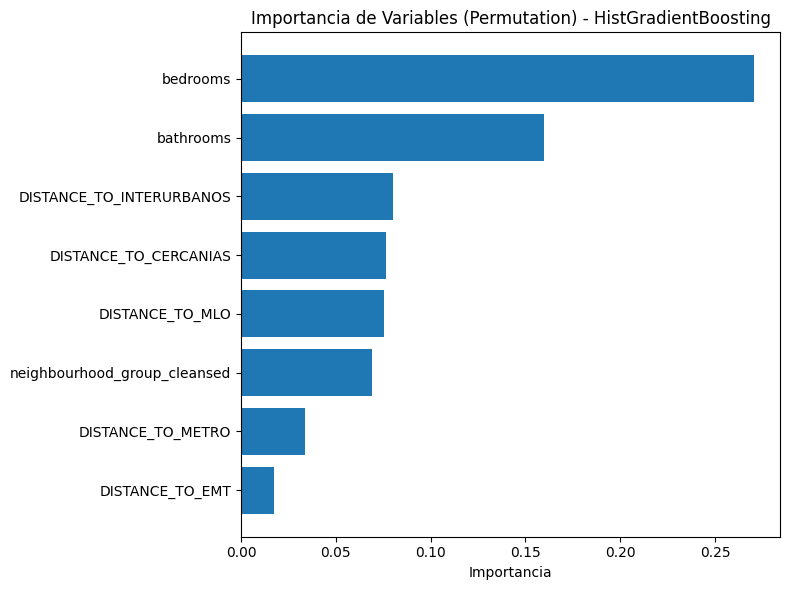

In [10]:
from sklearn.inspection import permutation_importance

result = permutation_importance(best_pipe, X, y, n_repeats=10, random_state=42, scoring='r2')

# DataFrame
perm_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)

# Gráfico
plt.figure(figsize=(8, 6))
plt.barh(perm_df['Feature'], perm_df['Importance'])
plt.gca().invert_yaxis()
plt.title(f'Importancia de Variables (Permutation) - {best_name}')
plt.xlabel('Importancia')
plt.tight_layout()
plt.show()

Persistimos para inferencia de otros datos con el mismo modelo:

In [11]:
model_path = f"pers_models/{best_name}.skops"
untrusted = get_untrusted_types(file=model_path) #Esto es una ñapa, porque debo confiar en la función lambda de densifier
print("Untrusted:", untrusted)
model = load(model_path, trusted=untrusted)
# pred = model.predict(new_data)

Untrusted: ['sklearn._loss.link.IdentityLink', 'sklearn._loss.link.Interval', 'sklearn._loss.loss.HalfSquaredError', 'sklearn.compose._column_transformer._RemainderColsList', 'sklearn.ensemble._hist_gradient_boosting.binning._BinMapper', 'sklearn.ensemble._hist_gradient_boosting.predictor.TreePredictor']
